# AWS Braket

## Reproducing the Educational Example (see Appendix A) of the paper PhysRevX.12.011059 by Sivak et al.

We want to implement a Reinforcement Learning (RL) model (which is a classical Neural Network) and train its agent to learn the rotation angle $\theta$ to flip the incoming quantum state $\ket{0}$ to the $\ket{1}$ state by applying a RX-gate($\theta$).

This code is implemented in ``PyTorch`` and bases its architecture on the one by Mr. Arthur Strauss who used ``TensorFlow`` (https://github.com/arthurostrauss/Quantum_Optimal_Control/tree/main/paper_results)

#### Imports

In [15]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import norm
from scipy.linalg import sqrtm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import torch.optim as optim

from braket.circuits import Circuit
from braket.devices import LocalSimulator

#### The RL agent performs an action

To measure in the Hadamard basis (or X-basis), you can use the Hadamard gate. Specifically, before performing the measurement on a qubit prepared in a certain state, apply a Hadamard gate. This gate transforms the state from the computational (Z) basis to the Hadamard (X) basis. After applying the Hadamard gate, you can measure in the usual Z-basis, which effectively corresponds to a measurement in the X-basis.

**To measure the $\ket{+}$ state in the Hadamard basis:**

- Apply a Hadamard gate on the qubit that's in the $\ket{+}$ state.
- Measure in the computational basis ($\ket{0}$ and $\braket{0}$).
- The outcome of the measurement is then in the Hadamard basis.

**To measure the $\ket{-}$ state in the Hadamard basis:**

- Apply a z-gate on the qubit
- Apply a Hadamard gate on the qubit that's in the $\ket{-}$ state.
- Measure in the computational basis ($\ket{0}$ and $\braket{0}$).
- The outcome of the measurement is then in the Hadamard basis.

Estimate a density matrix based on the binary (either 0 or 1) measurement outcomes of the quantum circuit

In [16]:
target_states = {
    '1': np.array([0, 1]),
    '+': (1/np.sqrt(2)) * np.array([+1, +1]),
    '-': (1/np.sqrt(2)) * np.array([+1, -1]),
}

In [17]:
def get_dm(state: np.ndarray) -> np.ndarray:
    return np.outer(state, np.conj(state))

def get_fidelity(rho, sigma):
    """
    Compute the fidelity between two quantum states represented by density matrices.
    
    Parameters:
    - rho (numpy.ndarray): Density matrix of the first quantum state.
    - sigma (numpy.ndarray): Density matrix of the second quantum state.
    
    Returns:
    - float: Fidelity between the two quantum states.
    
    Note:
    This function assumes that the input density matrices are valid (positive, trace 1) and of the same size.
    """
    
    # Computing the square root of rho
    sqrt_rho = sqrtm(rho)
    
    # Calculating the product sqrt_rho * sigma * sqrt_rho
    temp_product = np.dot(np.dot(sqrt_rho, sigma), sqrt_rho)
    
    # Taking the square root of the product
    root_product = sqrtm(temp_product)
    
    # Calculating the trace
    fidelity = np.real(np.trace(root_product))
    
    return fidelity

# Testing with example pure states, here orthogonal states (F = 0)
psi = np.array([1, 0])
phi = np.array([1, 0])

psi_dm = get_dm(state=psi)
phi_dm = get_dm(state=phi)

print(f'Fidelity F = {round(get_fidelity(psi_dm, phi_dm), 6)}')  # This should be close to 0 for orthogonal states

Fidelity F = 1.0


In [18]:
"""def estimate_dm(qc, estimated_dm, batch) -> np.ndarray:
    # Construct the estimated density matrix
    q_state = qi.Statevector.from_instruction(qc)
    estimated_dm += np.array(q_state.to_operator()) / batch 

    return estimated_dm"""

'def estimate_dm(qc, estimated_dm, batch) -> np.ndarray:\n    # Construct the estimated density matrix\n    q_state = qi.Statevector.from_instruction(qc)\n    estimated_dm += np.array(q_state.to_operator()) / batch \n\n    return estimated_dm'

In [19]:
target_state_str = '+'

target_state = target_states[target_state_str]
print('Target state:', target_state)

Target state: [0.70710678 0.70710678]


In [20]:
def perform_action(amp, shots=1, target_state_str=target_state_str):
    """
    Execute a quantum circuit with parametrized amplitude, retrieve measurement result and assign rewards accordingly
        
        :param amp: amplitude parameter, provided as an array of size batchsize
        :param shots: number of evaluations to be done on the quantum computer
        :param target: string indicating the target state ('1' or '+')
    
        :return: Reward table (reward for each run in the batch)
    """
    global qc, device, target_states
    angles, batch = np.array(amp), len(np.array(amp))
    reward_table = np.zeros(batch)

    # estimated_dm = np.zeros([2,2], dtype='complex128')

    for ind, angle in enumerate(angles):
        if target_state_str == '1':
            qc.rx(0, 2 * np.pi * angle)  # Add parametrized gate for each amplitude in the batch
            # estimate_dm(qc, estimated_dm, batch)
            
        elif target_state_str == '+':
            qc.ry(0, 2 * np.pi * angle)  # Add parametrized gate for each amplitude in the batch  
            #estimate_dm(qc, estimated_dm, batch)
            qc.h(0) # Transform to hadamard basis before measurement
            
        elif target_state_str == '-':
            qc.ry(0, 2 * np.pi * angle)
            #estimate_dm(qc, estimated_dm, batch)
            qc.z(0)  # Apply Z gate for the minus state
            qc.h(0) # Transform to hadamard basis before measurement
        
        # Running the circuit
        task = device.run(qc, shots=shots)
        result = task.result()
        counts = result.measurement_counts  # Returns a dict with keys '0' and '1' (possible measurement outcomes) with number of counts for each key
        
        # Calculate reward
        if target_state_str == '1':
            reward_table[ind] += np.mean(np.array([1] * counts.get('1', 0) + [-1] * counts.get('0', 0)))
        elif target_state_str in ['+', '-']:
            reward_table[ind] += np.mean(np.array([1] * counts.get('0', 0) + [-1] * counts.get('1', 0)))
        else:
            if ind % 10 == 0:
                print('!! Reward calculation FAILS !!')

        # qc.clear()

    return reward_table #, estimated_dm

#### Set Hyperparameters for the RL

In [21]:
# Define a quantum circuit with 1 qubit
qc = Circuit()
# Define the local simulator
device = LocalSimulator()

seed = 2364

eta = 0.01  # Learning rate for policy update step

## ATTENTION 
``n_epochs`` and ``batch_size`` are both major drivers of (possibly costly) simulation time

In [27]:
# Hyperparameters for the agent
n_epochs = 50
batch_size = 20

To minimize the number of measurements for the target state $\ket{1}$, we start with ideal initial paramaters, so with $\mu = 0.5$.

In [22]:
# Policy parameters
# mu = nn.Parameter(torch.randn([]) * 0.00005)  # Initializing mu with a value drawn from a normal distribution with mean 0, sigma 0.05
if target_state_str == '1':
    mu = nn.Parameter(0.5 + torch.randn([]) * 0.00005) 
sigma = nn.Parameter(torch.tensor(0.0005))  # Initializing sigma with a value of 0.05

# Critic parameter (single state-independent baseline b)
b = nn.Parameter(torch.tensor(0.))

#### Training

In [23]:
def constrain_mu(value, min_val, max_val):
    return torch.clamp(value, min_val, max_val)

def constrain_sigma(value):
    return torch.relu(value) # Ensures that sigma is non-negative

In [24]:
# def log_info(epoch, mu, sigma, reward, target_state, fidelity):

def log_info(epoch, mu, sigma, reward, target_state):
    print('\nEPOCH', epoch+1)
    print('Policy parameter')
    print(f'mu = {mu.item()} +- sigma = {sigma.item()}')
    print('baseline', b.item())
    print('Average Return:', reward.mean().item())
    print('Target state: ', target_state)
    # print('Fidelity: ', fidelity)

In [25]:
# Create an optimizer for the trainable parameters
optimizer = optim.Adam([mu, sigma, b], lr=eta)
epsilon = 1e-3 # Small offset to avoid sigma = 0
 # Clip the gradients
grad_clip = 0.3


# Dictionary to keep track of the used parameters
params = {
            'mu': [],
            'sigma': [],
            'reward': [],
            'fidelity': [],
            'learning_rate': eta,
            'seed': seed,
            'batch_size': batch_size,
            'n_epochs': n_epochs,
}

### Training loop
for epoch in tqdm(range(n_epochs)):

    # Sample action from policy (Gaussian distribution with parameters mu and sigma)
    Normal_distrib = Normal(loc=mu, scale=sigma + epsilon)
    action = Normal_distrib.sample((batch_size,)) # action 

    # Run quantum circuit to retrieve rewards (in this example, only one time step)
    # reward, estimated_dm = perform_action(action, shots=1, target_state_str=target_state_str)
    reward = perform_action(action, shots=1, target_state_str=target_state_str)

    target_state_dm = get_dm(target_states[target_state_str])
    # fidelity = get_fidelity(target_state_dm, estimated_dm)
    
    if epoch % 10 == 0:
        # log_info(epoch, mu, sigma, reward, target_state, fidelity) 
        log_info(epoch, mu, sigma, reward, target_state) 

    advantage = torch.tensor(reward, dtype=torch.float32) - b
    
    log_probs = Normal_distrib.log_prob(action)

    actor_loss = -(advantage * log_probs).mean()
    critic_loss = (advantage ** 2).mean()
    critic_loss_coeff = 0.5
    combined_loss = actor_loss + critic_loss_coeff * critic_loss

    # Clear previous gradients
    optimizer.zero_grad() 
    # Backpropagation
    combined_loss.backward()
    # Clip the gradients
    torch.nn.utils.clip_grad_norm_([mu, sigma, b], grad_clip)
    # Apply gradients
    optimizer.step()

    # During training, after each optimizer step:
    with torch.no_grad():
        mu.data = constrain_mu(mu.data, -2., 2.)
        sigma.data = constrain_sigma(sigma.data)
  
    params["mu"].append(mu.item())
    params["sigma"].append(sigma.item())
    params["reward"].append(reward)
    # params["fidelity"].append(fidelity)

  2%|▏         | 1/50 [00:00<00:06,  7.80it/s]


EPOCH 1
Policy parameter
mu = -0.05243176966905594 +- sigma = 0.0005000000237487257
baseline 0.0
Average Return: 0.4
Target state:  [0.70710678 0.70710678]


 22%|██▏       | 11/50 [00:11<01:00,  1.54s/it]


EPOCH 11
Policy parameter
mu = -0.07252800464630127 +- sigma = 0.0
baseline -0.09951739013195038
Average Return: 0.1
Target state:  [0.70710678 0.70710678]


 42%|████▏     | 21/50 [00:40<01:37,  3.36s/it]


EPOCH 21
Policy parameter
mu = -0.07819131016731262 +- sigma = 0.0
baseline -0.19795241951942444
Average Return: 0.1
Target state:  [0.70710678 0.70710678]


 62%|██████▏   | 31/50 [01:29<01:40,  5.27s/it]


EPOCH 31
Policy parameter
mu = -0.043463289737701416 +- sigma = 0.0
baseline -0.29911190271377563
Average Return: 0.2
Target state:  [0.70710678 0.70710678]


 82%|████████▏ | 41/50 [02:37<01:05,  7.23s/it]


EPOCH 41
Policy parameter
mu = -0.040691059082746506 +- sigma = 0.0
baseline -0.39322391152381897
Average Return: 0.4
Target state:  [0.70710678 0.70710678]


100%|██████████| 50/50 [03:54<00:00,  4.70s/it]


#### Visualization

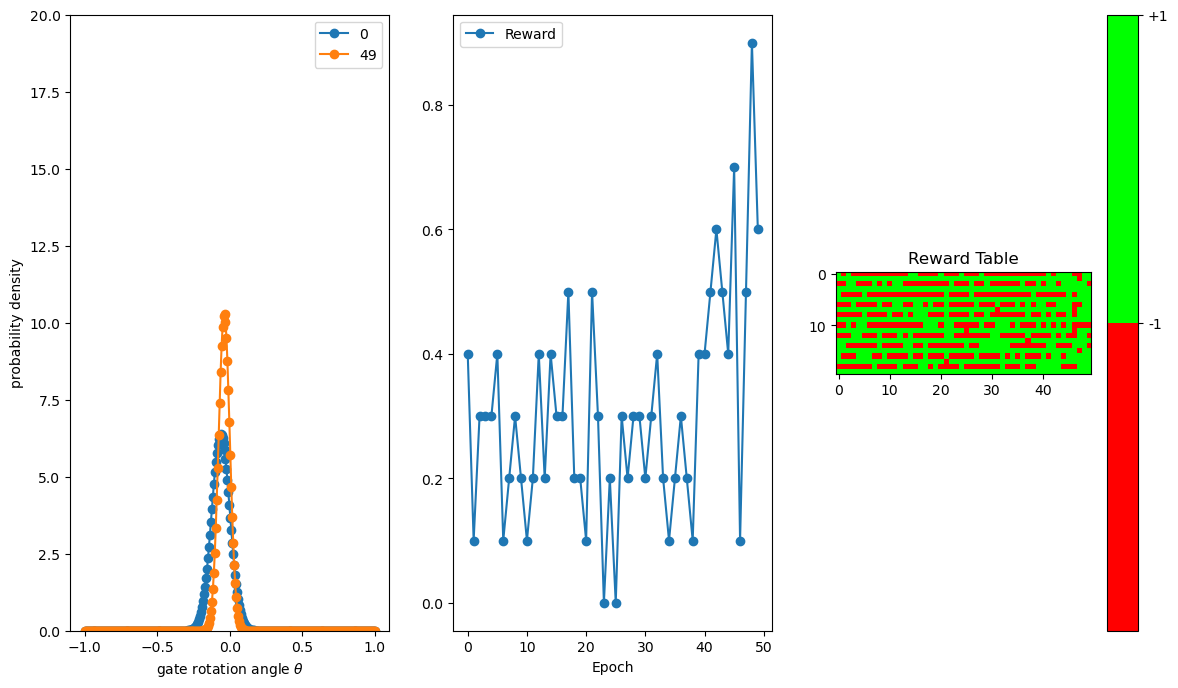

In [26]:
x = np.linspace(-1., 1., 300)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 8))
# Plot probability density associated to updated parameters for a few steps
for i in np.linspace(0, n_epochs-1, n_epochs//25, dtype=int):
    ax1.plot(x, norm.pdf(x, loc=params["mu"][i], scale=np.abs(params["mu"][i])), '-o', label=f'{i}')

ax1.set_xlabel(r"gate rotation angle $\theta$")
ax1.set_ylabel("probability density")
ax1.set_ylim(0., 20)
#  Plot return as a function of epochs
ax2.plot(np.mean(params["reward"], axis=1), '-o', label='Reward')
# ax2.plot(params["fidelity"], '-o', label='Fidelity')
ax2.set_xlabel("Epoch")
ax2.legend()
ax1.legend()

rewards = np.array(params['reward']).transpose()
# Create a custom colormap
colors = [(1, 0, 0), (0, 1, 0)]  # R -> G
cmap_name = 'custom_red_green'
cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=2)

# Dummy data and imshow for ax3
cax = ax3.imshow(rewards, cmap=cm)
ax3.set_title("Reward Table")

# Add colorbar to ax3
cbar = fig.colorbar(cax, ax=ax3, ticks=[0, 1])
cbar.ax.set_yticklabels(['-1', '+1'])

plt.show()